In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.transforms import *
from fastai.models.resnet import vgg_resnet50
from sklearn.metrics import roc_auc_score
import pixiedust
from matplotlib.patches import Rectangle
from datetime import datetime


Pixiedust database opened successfully


In [3]:
PATH = Path('/mnt/data/xray-thesis/data/chestX-ray14')
IMAGE_DN = 'images'
TRAIN_CSV = 'train_list.csv'
TEST_CSV = 'test_list.csv'
arch = densenet121
N_CLASSES = 15
model_name = datetime.strftime(datetime.now(), '%Y%m%d-%H%M%S')
model_name

'20190104-202813'

## Load dataset

In [4]:
def aucs(targets, preds):
    aurocs = []
    for i in range(N_CLASSES):
        aurocs.append(roc_auc_score(targets[:, i], preds[:, i]))
    return aurocs

In [5]:
def get_data(sz, bs):
    aug_tmfs = [RandomScale(sz, sz*1.5),
                RandomFlip(),
                RandomCrop(sz)]
    tmfs = tfms_from_model(arch, sz, aug_tmfs)
    md = ImageClassifierData.from_csv(PATH, 'images', PATH/TRAIN_CSV, bs, tmfs, cat_separator='|')
    return md

In [6]:
md = get_data(sz=64, bs=8)

## Densenet121 arch with binary classification

In [7]:
class LSEPool2d(nn.Module):
    
    def __init__(self, r=3):
        super().__init__()
        self.r =r
    
    def forward(self, x):
        s = x.size()[3]  # x: bs*2048*7*7
        r = self.r
        x_max = F.adaptive_max_pool2d(x, 1) # x_max: bs*2048*1*1
        p = ((1/r) * torch.log((1 / (s*s)) * torch.exp(r*(x - x_max)).sum(3).sum(2)))
        x_max = x_max.view(x.size(0), -1) # bs*2048
        return x_max+p


class WeightedBCELoss(nn.Module):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, input, target):
        w = self.get_weight(input, target)
        return F.binary_cross_entropy_with_logits(input, target, w, reduction='mean')
    
    def get_weight(self, input, target):
        y = target.cpu().data.numpy()
        y_hat = input.cpu().data.numpy()
        P = np.count_nonzero(y == 1)
        N = np.count_nonzero(y == 0)
        beta_p = (P + N) / (P + 1) # may not contain disease 
        beta_n = (P + N) / N 
        w = np.empty(y.shape)
        w[y==0] = beta_n
        w[y==1] = beta_p
        w = torch.FloatTensor(w).cuda()
        return w
    
# class FocalLoss(WeightedBCELoss):
    
#     def __init__(self, theta=2):
#         super().__init__()
#         self.theta = theta
        
#     def forward(self, input, target):
# #         pt = target*input + (1-target)*(1-input)
# #         target *= (1-pt)**self.theta
#         w = self.get_weight(input, target)
#         return F.binary_cross_entropy_with_logits(input, target, w)

    
        
densenet_head = nn.Sequential(LSEPool2d(1), 
                     nn.Linear(1024, 15))


In [9]:
# class FocalLoss(nn.Module):
#     def __init__(self, gamma=0, alpha=None, size_average=True):
#         super(FocalLoss, self).__init__()
#         self.gamma = gamma
#         self.alpha = alpha
#         if isinstance(alpha,(float,int,long)): self.alpha = torch.Tensor([alpha,1-alpha])
#         if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
#         self.size_average = size_average

#     def forward(self, input, target):
#         if input.dim()>2:
#             input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
#             input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
#             input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
#         target = target.view(-1,1)

#         logpt = F.log_softmax(input)
#         logpt = logpt.gather(1,target)
#         logpt = logpt.view(-1)
#         pt = Variable(logpt.data.exp())

#         if self.alpha is not None:
#             if self.alpha.type()!=input.data.type():
#                 self.alpha = self.alpha.type_as(input.data)
#             at = self.alpha.gather(0,target.data.view(-1))
#             logpt = logpt * Variable(at)

#         loss = -1 * (1-pt)**self.gamma * logpt
#         if self.size_average: return loss.mean()
#         else: return loss.sum()

In [8]:
densenet_model = ConvnetBuilder(arch, 0, 0, 0, xtra_cut=1, custom_head=densenet_head)
learn = ConvLearner(md, densenet_model)
learn.crit = WeightedBCELoss()

/home/dattran/miniconda3/envs/thesis/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
/home/dattran/miniconda3/envs/thesis/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
/home/dattran/miniconda3/envs/thesis/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
/home/dattran/miniconda3/envs/thesis/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
/home/dattran/miniconda3/envs/thesis/lib/python3.7/site-packages/torchvi

In [11]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('trainable', False),
                           ('nb_params', tensor(9408))])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('trainable', False),
                           ('nb_params', tensor(128))])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
                           ('output_shape', [-1, 64, 16, 16]),
                           ('nb_params', 0)])),
             ('BatchNorm2d-5',
              OrderedDict([('input_shape', [-1, 6

In [11]:
learn[-1]

Sequential(
  (0): LSEPool2d()
  (1): Linear(in_features=1024, out_features=15, bias=True)
)

In [12]:
# learn.freeze_to(-1)
# learn.lr_find()

In [13]:
learn.sched.plot(0, 700)

AttributeError: 'NoneType' object has no attribute 'plot'

In [72]:
# lr = 1e-4
# learn.fit(lr, 3)

epoch      trn_loss   val_loss   <lambda>                      
    0      0.184582   0.198487   0.924108  
    1      0.181523   0.186143   0.935718                      
    2      0.183279   0.182181   0.935939                      


[0.18218121799079057, 0.9359388083379633]

In [2]:
py, y = learn.TTA()
aucs = aucs(y, np.mean(py, axis=0))
np.mean(aucs)

In [ ]:
lr = 1e-4
learn.set_data(get_data(128, 32)) # 64, 64: 1GB; 128, 64: 4GB
learn.fit(lr, 1)

  0%|          | 0/2118 [00:00<?, ?it/s]

In [92]:
learn.save('tmp')

In [10]:
learn.load('tmp')

RuntimeError: unexpected EOF, expected 8 more bytes. The file might be corrupted.

## Class Activation Map

In [ ]:
x, y = next(iter(md.val_dl))
x, y = x[None, 1], y[None, 1]

In [33]:
class FeatureHook:
    features = None
    
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output):
        self.features = output
        
    def remove(self):
        self.hook.remove()
        
class WeightHook:
    weights = None

    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output):
        self.weights = list(module.parameters())[0].data
    
    def remove(self):
        self.hook.remove()

last_conv_layer = learn[-2][-1]
linear_layer = learn[-1][2]
feat = FeatureHook(last_conv_layer)
weig = WeightHook(linear_layer)

py = learn.model(x)

feat.remove()
weig.remove()

In [64]:
learn[-2][-1]

Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
)

In [42]:
feat.features.shape, weig.weights.shape

(torch.Size([1, 2048, 7, 7]), torch.Size([15, 2048]))

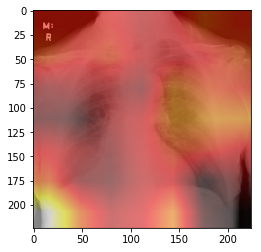

In [46]:
feat.features[0]
i = y.argmax()
f2 = np.dot(np.rollaxis(to_np(feat.features[0]), 0, 3), to_np(weig.weights[i]))
f2 -= f2.min()
f2 /= f2.max()
# get the CAM for correct class
plt.imshow(md.val_ds.denorm(x)[0])
plt.imshow(cv2.resize(f2, (224, 224)), alpha=0.5, cmap='hot')

In [29]:
%who FeatureHook

No variables match your requested type.


In [32]:
%reset_selective -f weig

## Activation Heat Map

tensor([[[0.0000, 0.4368, 0.1588,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0778,  ..., 1.0262, 0.0000, 0.0000],
         [0.2853, 0.0000, 0.0000,  ..., 2.5021, 0.9389, 0.3140],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.7014, 0.0842, 0.0000],
         [0.0000, 0.0571, 0.4116,  ..., 0.0457, 0.0000, 0.0000],
         [0.0000, 0.3224, 2.4255,  ..., 0.0000, 0.0000, 0.0587]],

        [[1.2536, 3.2189, 1.2877,  ..., 0.5058, 0.4746, 0.1999],
         [1.0801, 2.4814, 0.6545,  ..., 0.7244, 0.4180, 0.0000],
         [0.7979, 0.6545, 2.2578,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.4249,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.2440, 0.0000, 0.5543],
         [1.5833, 0.1206, 0.0000,  ..., 0.7257, 0.7236, 1.0872]],

        [[0.0000, 0.5081, 0.0446,  ..., 0.2226, 0.2119, 0.0131],
         [0.0000, 1.1610, 0.0000,  ..., 0.0000, 0.9281, 2.3560],
         [0.0000, 1.1074, 0.0000,  ..., 2.6352, 1.6342, 3.

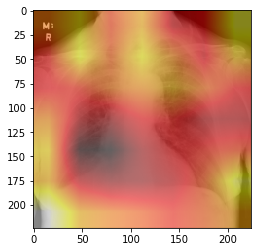

In [62]:
H = torch.max(feat.features[0], dim=0)
plt.imshow(md.val_ds.denorm(x)[0])
plt.imshow(cv2.resize(to_np(H[0]), (224, 224)), alpha=0.5, cmap='hot')
feat.features[0]

In [60]:
theta = .7
slice_x, slice_y = ndimage.find_objects(h[0] > theta, True)[0]
H[0]
rect = Rectangle(xy, width, height, linewidth=1,edgecolor='r',facecolor='none')

# plt.imshow(, (224, 224)))

tensor([[4.8928, 5.9566, 4.2825, 5.3945, 3.4920, 3.8588, 6.3974],
        [3.9107, 6.2454, 4.5981, 6.0886, 5.0020, 3.6038, 5.5754],
        [3.7509, 4.0831, 4.8184, 5.0620, 5.5018, 4.7233, 3.8376],
        [5.0277, 3.2470, 3.0025, 3.7908, 3.9190, 3.1803, 3.1831],
        [5.8178, 1.8233, 1.5675, 2.9644, 3.7457, 3.9850, 4.2777],
        [5.4064, 3.3734, 2.7829, 2.8314, 3.3495, 4.4601, 6.5072],
        [7.6695, 5.4467, 4.9027, 4.5113, 3.9914, 4.5351, 5.2755]],
       device='cuda:0')

## Knn for similar image

## Focal loss